# Data Preprocessing

In this section, we will attempt to clean the following datasets:
   - TLC Yellow Taxi Trips Record 2021/10-2022-04


<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

<div class="alert alert-block alert-success">
<b>Up to you:</b> Use green boxes sparingly, and only for some specific 
purpose that the other boxes can't cover. For example, if you have a lot 
of related content to link to, maybe you decide to use green boxes for 
related links from each section of a notebook.
</div>

***

## Import Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

## Exploratory Data Analysis

In [2]:
# Starting a Spark session
spk = (
    SparkSession.builder.appName('Playground')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .getOrCreate()
)

# Read the parquet dataset
df = spk.read.parquet('/Users/oliver/Downloads/MAST30034_Python-main/data/tlc_data')

In [3]:
# Inspect the metadata
df.printSchema()

print("Number of instances: ", df.count(), '\n',
      "Number of features: ", len(df.columns))

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

Number of instances:  22821986 
 Number of features:  19


In [4]:
# Make all variable names consistent
column_name = {'VendorID': 'vendor_id', 
               'RatecodeID': 'rate_code_id', 
               'PULocationID': 'pu_location_id',
               'DOLocationID': 'do_location_id'}

for key, value in column_name.items():
    df = df.withColumnRenamed(key,value)

In [5]:
# Check variable names
df.columns

['vendor_id',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'rate_code_id',
 'store_and_fwd_flag',
 'pu_location_id',
 'do_location_id',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

## Check for outliers in the data based on each feature

In [41]:
# Extract trip duration in minutes
df = df.withColumn('trip_duration_min',
                   (func.col('tpep_dropoff_datetime').cast('long') - 
                    func.col('tpep_pickup_datetime').cast('long')) / 60)

# Extract the date as a standalone feature
df = df.withColumn("pickup_date", 
                   func.to_date(func.col("tpep_pickup_datetime")))

df = df.withColumn("dropoff_date",
                   func.to_date(func.col("tpep_dropoff_datetime")))


In [43]:
# Check earliest and latest of datetime variables
print("tpep_pickup_datetime:\n\tMax:", df.agg({"tpep_pickup_datetime": "max"}).collect()[0][0],
     "\n\tMin:", df.agg({"tpep_pickup_datetime": "min"}).collect()[0][0])

print("\ntpep_dropoff_datetime:\n\tMax:", df.agg({"tpep_dropoff_datetime": "max"}).collect()[0][0],
     "\n\tMin:", df.agg({"tpep_dropoff_datetime": "min"}).collect()[0][0], '\n')

# Check shortest and longest trip duration
# print("trip_duration_min:\n\tMax:", df.agg({"trip_duration_min": "max"}).collect()[0][0],
#      "\n\tMin:", df.agg({"trip_duration_min": "min"}).collect()[0][0])

# Check other variables
df.select(['passenger_count',
           'trip_distance',
           'trip_duration_min',
           'fare_amount',
           'extra',
           'mta_tax',
           'tip_amount',
           'tolls_amount',
           'improvement_surcharge',
           'total_amount',
           'congestion_surcharge',
           'airport_fee']).describe().show(vertical=True)

tpep_pickup_datetime:
	Max: 2028-12-07 15:48:15 
	Min: 2003-01-01 11:10:06

tpep_dropoff_datetime:
	Max: 2028-12-07 16:29:13 
	Min: 2003-01-01 11:38:46 

-RECORD 0------------------------------------
 summary               | count               
 passenger_count       | 22045834            
 trip_distance         | 22821986            
 trip_duration_min     | 22821986            
 fare_amount           | 22821986            
 extra                 | 22821986            
 mta_tax               | 22821986            
 tip_amount            | 22821986            
 tolls_amount          | 22821986            
 improvement_surcharge | 22821986            
 total_amount          | 22821986            
 congestion_surcharge  | 22045834            
 airport_fee           | 22045834            
-RECORD 1------------------------------------
 summary               | mean                
 passenger_count       | 1.410832132728569   
 trip_distance         | 6.379380374258177   
 trip_duration_min

Despite having retrieved the data from 2021-10 to 2022-04, the dataset still contains records from previous years. The numerical features such as `trip_distance`, `fare_amount`, `tolls_amount`, `total_amount`, `trip_duration` also contain unrealistic values which need to be removed.

## Data Cleaning

To clean the code, we need to first consider the minimum possible and logical value for each column:
- `extra`, `mta_tax`, `tip_amount`, `tolls_amount`, `improvement_surcharge`, `congestion_surcharge` and `airport_fee` can take value greater or equal to 0.
- `passenger_count` must take value greater or equal to 1.
- We assume that the minimum `trip_distance` and `trip_duration_min` for a regular ride is atleast 0.5 miles and 1 min respectively.
- Based on the TLC website, the initial fare of each ride is \$2.5 so we assume that minimum `fare_amount` is \$2.5

In [62]:
# Filter based on the minimum possible values for numerical features
df1 = df.where((func.col('passenger_count') > 0) &
               (func.col('trip_distance') > 0.5) &
               (func.col('trip_duration_min') > 1) &
               (func.col('fare_amount') >= 2.50) &
               (func.col('extra') >= 0) &
               (func.col('mta_tax') >= 0) &
               (func.col('tip_amount') >= 0) &
               (func.col('tolls_amount') >= 0) &
               (func.col('improvement_surcharge') >= 0) &
               (func.col('total_amount') >= 0) &
               (func.col('congestion_surcharge') >= 0) &
               (func.col('airport_fee') >= 0))

Since the dataset is too large, it is not feasible to check the outlier individually for each numerical column. So instead, we looked at the 99.99th percentile of the data and decide if the value is logical and possible.

We also capped the `trip_duration_min` to atmost 5 hours (300 mins).

In [63]:
# Filter the columns to cover 99.99 percentile of the data for numerical features
df1 = df1.where((func.col('fare_amount') <= df1.selectExpr('percentile(fare_amount, 0.9999)').collect()[0][0]) &
                (func.col('trip_distance') <= df1.selectExpr('percentile(trip_distance, 0.9999)').collect()[0][0]) &
                (func.col('tip_amount') <= df1.selectExpr('percentile(tip_amount, 0.9999)').collect()[0][0]) &
                (func.col('total_amount') <= df1.selectExpr('percentile(total_amount, 0.9999)').collect()[0][0]) &
                (func.col('tolls_amount') <= df1.selectExpr('percentile(tolls_amount, 0.9999)').collect()[0][0]) &
                (func.col('trip_duration_min') <= 300))

In [64]:
# Filter the period to between 2021-10 to 2022-04
df1 = df1.where((func.col("pickup_date") >= '2021-10-01') & 
                (func.col("dropoff_date") >= '2021-10-01') &
                (func.col("pickup_date") <= '2022-04-30') & 
                (func.col("dropoff_date") <= '2022-04-30'))

In [65]:
# Check the descriptive statistics of all numerical columns
df1.select(['passenger_count',
           'trip_distance',
           'trip_duration_min',
           'fare_amount',
           'extra',
           'mta_tax',
           'tip_amount',
           'tolls_amount',
           'improvement_surcharge',
           'total_amount',
           'congestion_surcharge',
           'airport_fee',
           'pickup_date']).describe()


summary,passenger_count,trip_distance,trip_duration_min,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,20250570,20250570,20250570,20250570,20250570,20250570,20250570,20250570,20250570,20250570,20250570,20250570
mean,1.4468479652671504,3.394968382122594,15.165714772473084,13.875580277000775,1.0274034054350067,0.49783568610661383,2.6136837140881326,0.4653933118937502,0.29998946698134965,20.52423191888724,2.34338506521051,0.0864368262226693
stddev,0.9877235759123165,4.165892475089207,11.505245244764664,11.702719724930523,1.2362913136801421,0.03353720181975423,2.789518530541847,1.8118331365778686,0.001777582702865154,14.914068090147707,0.6058111434688664,0.31713516490197763
min,1.0,0.51,1.0166666666666666,2.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
max,9.0,57.3,299.9166666666667,200.0,33.5,17.1,50.0,25.8,0.3,231.85,2.75,1.25


In [66]:
# Check period of data
pu_earliest, pu_latest = df1.select(min("pickup_date"), max("pickup_date")).first()
do_earliest, do_latest = df1.select(min("dropoff_date"), max("dropoff_date")).first()

print(f"pickup_date: {pu_earliest} - {pu_latest}")
print(f"dropoff_date: {do_earliest} - {do_latest}")

pickup_date: 2021-10-01 - 2022-04-30
dropoff_date: 2021-10-01 - 2022-04-30


The dataset looks much cleaner now and easier to work with. In the following parts, we will begin feature engineering to facilitate our analysis later on.

## Feature Engineering

In this part, we attempt to generate features that may be helpful with our analysis.

In [68]:
# Generate the average speed (miles/hour) for each trip 
df1 = df1.withColumn('average_speed',
                      func.col('trip_distance') / (func.col('trip_duration_min') / 60))

# Encode 

In [75]:
df1.select(['average_speed']).describe()

summary,average_speed
count,20250570
mean,12.204450600150766
stddev,7.215607152368692
min,0.11860167164907572
max,2500.8


In [74]:
df1.selectExpr('percentile(average_speed, 0.9999)').collect()[0][0]

79.24502378396616

### Extract demand of pick up every hour

In [76]:
df1.columns

['vendor_id',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'rate_code_id',
 'store_and_fwd_flag',
 'pu_location_id',
 'do_location_id',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'trip_duration_min',
 'pickup_date',
 'dropoff_date',
 'average_speed']

In [106]:
pickup_demand = (df1
  .withColumn("pickup_time", func.col("tpep_pickup_datetime").cast("timestamp"))
  .withColumn("date", func.col("tpep_pickup_datetime").cast("date"))
  .withColumn("hour", func.hour(func.col("tpep_pickup_datetime"))))

dropoff_demand = (df1
  .withColumn("dropoff_time", func.col("tpep_dropoff_datetime").cast("timestamp"))
  .withColumn("date", func.col("tpep_dropoff_datetime").cast("date"))
  .withColumn("hour", func.hour(func.col("tpep_dropoff_datetime"))))

In [107]:
aggs_pickup = pickup_demand.groupBy("pu_location_id","date", "hour").count()
aggs_dropoff = dropoff_demand.groupBy("do_location_id","date", "hour").count()

In [87]:
aggs

pu_location_id,date,hour,count
68,2022-03-01,11,37
43,2022-03-01,12,2
42,2022-03-01,16,2
229,2022-03-01,19,156
171,2022-03-01,21,1
17,2022-03-02,3,1
177,2022-03-02,5,1
146,2022-03-02,6,5
230,2022-03-02,10,179
262,2022-03-02,14,1


In [108]:
one_day_wtc_pickup_demand = aggs_pickup.where((func.col('pu_location_id') == 261) & 
                                              (func.col('date') == '2022-02-15')).toPandas()

one_day_wtc_dropoff_demand = aggs_dropoff.where((func.col('do_location_id') == 261) & 
                                                (func.col('date') == '2022-02-15')).toPandas()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='hour', ylabel='count'>

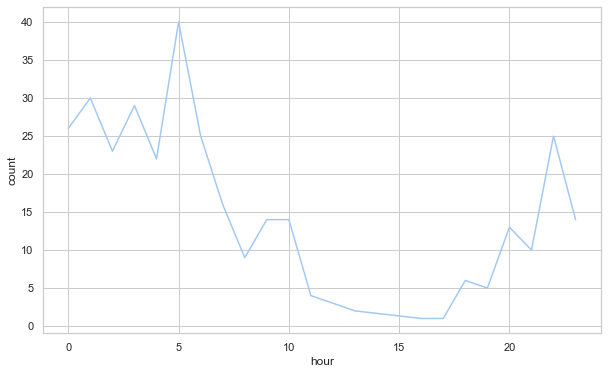

In [105]:
sns.lineplot('hour', 'count', data=one_day_wtc_pickup_demand)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='hour', ylabel='count'>

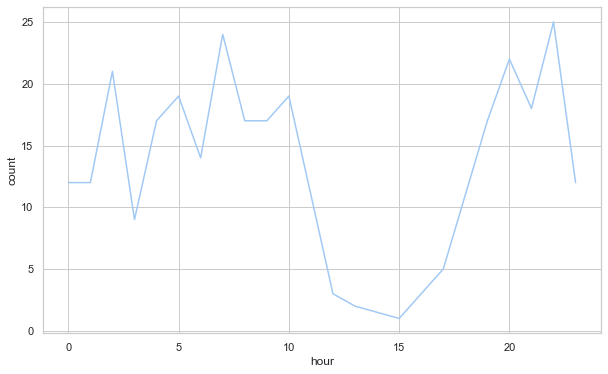

In [109]:
sns.lineplot('hour', 'count', data=one_day_wtc_dropoff_demand)